<a href="https://colab.research.google.com/github/sskyau/stanford-dogs-classification-models/blob/main/InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment Initialisation**

##1.1 Import libraries

In [ ]:
!pip install --upgrade pip
!pip install tensorflow-datasets
!pip install tensorflow_data_validation[visualization]==1.8.0 tensorflow==2.8
!pip install keract
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [1]:
# tf/keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_data_validation as tfdv
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.model_selection import KFold, StratifiedKFold

# utlity
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter


%load_ext tensorboard

##1.2 Check connection to GPU and drive

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


##1.3 Declare constant variables

In [4]:
IMG_SIZE = 224
NUM_BREEDS = 120
CP_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/InceptionResNetV2'

#**2. Load dataset**

#2.1 Load and visualise data

In [5]:
(train, val, test), info = tfds.load(name="stanford_dogs", 
                                     split=['train[:80%]+test[:80%]','train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]'],
                                     shuffle_files=True,
                                     as_supervised=True, # tuple instead of dictionary
                                     with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZAYA6K/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZAYA6K/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
class_labels = info.features['label'].int2str

print('Number of classes: ', info.features['label'].num_classes)
print()
print('Number of samples:')
print('Training set: ', len(train))
print('Validation set: ', len(val))
print('Testing set: ', len(test))
print()
print(info)

Number of classes:  120

Number of samples:
Training set:  16464
Validation set:  2058
Testing set:  2058

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='~/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
      

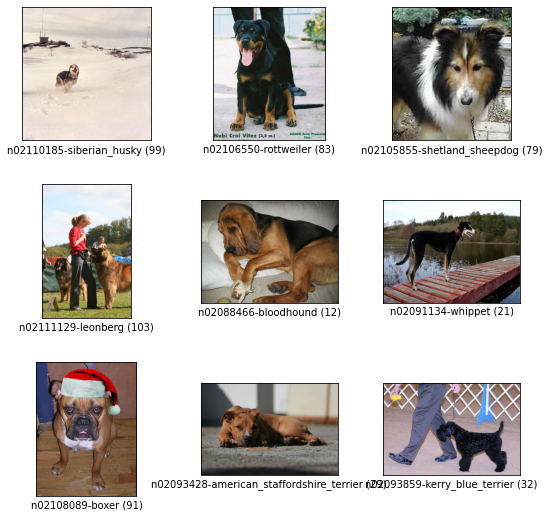

In [ ]:
fig = tfds.show_examples(train, info)

##2.2 Retrieve breed list

In [ ]:
breed_list = []

for filename in info.features['label'].names:
  separator = [i for i, letter in enumerate(filename) if letter == '-']
  breed_list.append(filename[separator[0]+1:])

print(breed_list)

['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih-tzu', 'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback', 'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone', 'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound', 'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound', 'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier', 'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier', 'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier', 'wire-haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier', 'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'scotch_terrier', 'tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa', 'flat-coated_retriever', 'cur

##2.3 Visualise dataset distributions

In [ ]:
train_labels, train_counts = np.unique(np.fromiter(train.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

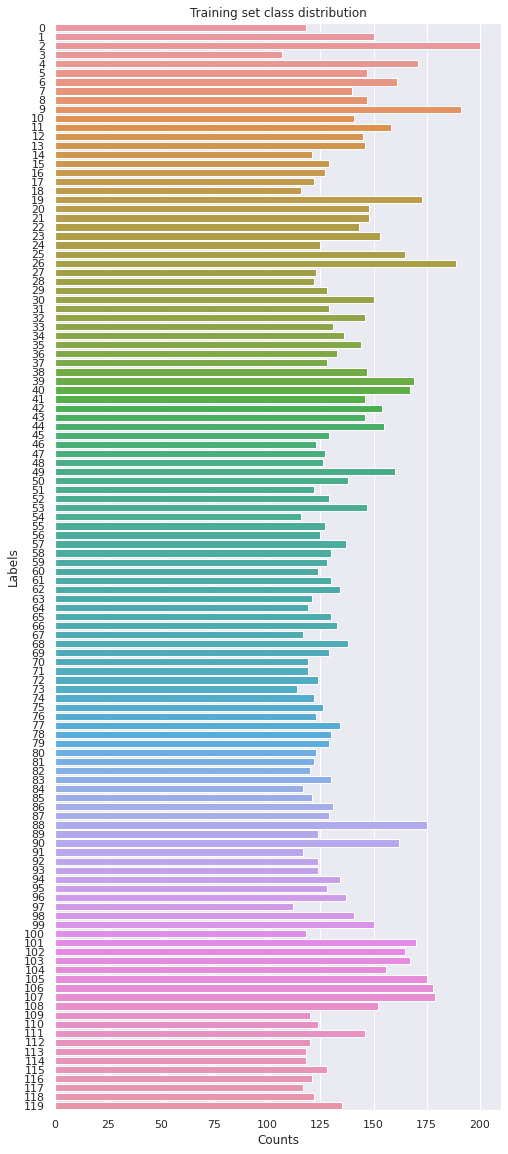

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Training set class distribution")
sns.barplot(x = train_counts, y = train_labels, orient='h') 

In [ ]:
val_labels, val_counts = np.unique(np.fromiter(val.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = val_counts, y = val_labels, orient='h') 

In [ ]:
test_labels, test_counts = np.unique(np.fromiter(test.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = test_counts, y = test_labels, orient='h') 

#**3. Modelling**

##3.1 Preprocessing Layers

In [7]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64
RANDOM_SEED = 43

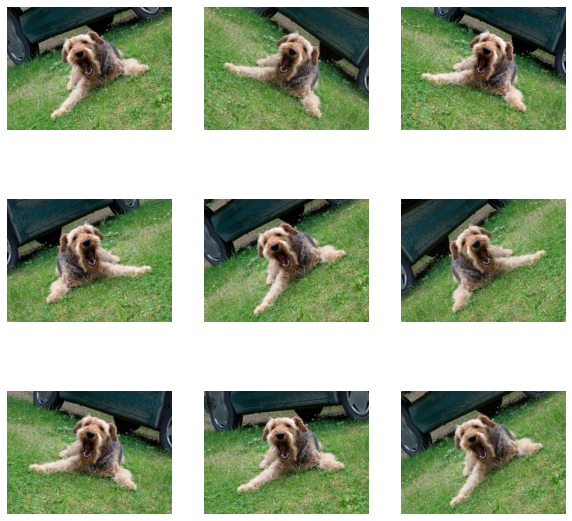

In [8]:
# Visualize some augmentations

img_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(factor=0.1),
                                        ])

ex_img, label = next(iter(train))
ex_img = tf.cast(ex_img, tf.float32) / 255.

img_batch = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)
 
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_img = img_augmentation(img_batch, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_img[0])
  plt.axis("off")

In [9]:
# Resize and one-hot encode all datasets

def one_hot(image, label):
  label = tf.one_hot(label,NUM_BREEDS)
  return image, label

def resize(image, label):
  image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
  return image, label

def preprocess(image, label):
  return tf.keras.applications.inception_resnet_v2.preprocess_input(tf.cast(image, tf.float32)), label

ds_train = train.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_val = val.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE, drop_remainder=True)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)


ds_test = test.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [10]:
def create_model():
  inputs = Input(shape=INPUT_SHAPE)
  x = img_augmentation(inputs)
  base = tf.keras.applications.InceptionResNetV2(input_tensor=x,
                                                input_shape=INPUT_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  base.trainable = False

  x = GlobalAveragePooling2D()(base.output)
  x = layers.BatchNormalization()(x)
  x = Dense(1280, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(RANDOM_SEED), bias_initializer='zeros')(x)
  x = layers.BatchNormalization()(x)
  outputs = Dense(NUM_BREEDS, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

  return Model(inputs=inputs, outputs=outputs, name='MNV2')

In [11]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

model.summary()

219070464/219055592 [==============================] - 2s 0us/step
Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['sequential[0][0]']             
                            

In [12]:
EPOCHS = 45
CP_PATH = CP_DIR+'/FE/InceptionResNetV2-{epoch:02d}.h5'

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(ds_train, 
                    epochs=EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

# save the model if results are satisfactory
model.save(CP_DIR+'/model/InceptionResNetV2.h5')

Epoch 1/45
257/257 [==============================] - 110s 272ms/step - loss: 1.6512 - accuracy: 0.7255 - top_k_categorical_accuracy: 0.9089 - val_loss: 0.5908 - val_accuracy: 0.8364 - val_top_k_categorical_accuracy: 0.9810
Epoch 2/45
257/257 [==============================] - 60s 235ms/step - loss: 0.7882 - accuracy: 0.7868 - top_k_categorical_accuracy: 0.9582 - val_loss: 0.5157 - val_accuracy: 0.8584 - val_top_k_categorical_accuracy: 0.9785
Epoch 3/45
257/257 [==============================] - 55s 213ms/step - loss: 0.6993 - accuracy: 0.8036 - top_k_categorical_accuracy: 0.9669 - val_loss: 0.5251 - val_accuracy: 0.8540 - val_top_k_categorical_accuracy: 0.9819
Epoch 4/45
257/257 [==============================] - 55s 214ms/step - loss: 0.6668 - accuracy: 0.8073 - top_k_categorical_accuracy: 0.9711 - val_loss: 0.5407 - val_accuracy: 0.8433 - val_top_k_categorical_accuracy: 0.9814
Epoch 5/45
257/257 [==============================] - 58s 227ms/step - loss: 0.6401 - accuracy: 0.8085 - to

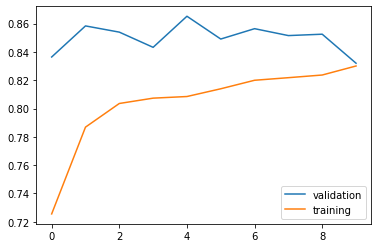

In [15]:
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='training')
plt.legend()
plt.show()

In [16]:
logname = CP_DIR + '/FE.csv'

df_history = pd.DataFrame.from_dict(history.history) 
df_history.to_csv (logname, index = False, header=True)

##3.3 Finetuning

In [ ]:
def print_trainable(model):
  for layer_id, layer in enumerate(model.layers):
    print(layer_id,' ' , layer.name, ": ", layer.trainable)

In [17]:
ft_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/InceptionResNetV2/FE/InceptionResNetV2-05.h5")

def unfreeze(model, start_layer, end_layer):
  for layer_id, layer in enumerate(model.layers):
    if layer_id >= start_layer and layer_id <= end_layer:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

unfreeze(ft_model, 0, len(ft_model.layers)-1)

In [ ]:
print_trainable(ft_model)

0   input_2 :  True
1   sequential :  True
2   conv2d_203 :  False
3   batch_normalization_205 :  False
4   activation_203 :  False
5   conv2d_204 :  False
6   batch_normalization_206 :  False
7   activation_204 :  False
8   conv2d_205 :  False
9   batch_normalization_207 :  False
10   activation_205 :  False
11   max_pooling2d_4 :  False
12   conv2d_206 :  False
13   batch_normalization_208 :  False
14   activation_206 :  False
15   conv2d_207 :  False
16   batch_normalization_209 :  False
17   activation_207 :  False
18   max_pooling2d_5 :  False
19   conv2d_211 :  False
20   batch_normalization_213 :  False
21   activation_211 :  False
22   conv2d_209 :  False
23   conv2d_212 :  False
24   batch_normalization_211 :  False
25   batch_normalization_214 :  False
26   activation_209 :  False
27   activation_212 :  False
28   average_pooling2d_1 :  False
29   conv2d_208 :  False
30   conv2d_210 :  False
31   conv2d_213 :  False
32   conv2d_214 :  False
33   batch_normalization_210 :  Fal

In [18]:
ft_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ft_model.summary()

Model: "MNV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['sequential[0][0]']             
                                )                                                              

In [19]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

CP_PATH = CP_DIR+'/FT/InceptionResNetV2-{epoch:02d}.h5'

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

FT_EPOCHS = 30
ft_history = ft_model.fit(ds_train, 
                    epochs=FT_EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

Epoch 1/30
257/257 [==============================] - 198s 687ms/step - loss: 0.4717 - accuracy: 0.8551 - top_k_categorical_accuracy: 0.9880 - val_loss: 0.4300 - val_accuracy: 0.8740 - val_top_k_categorical_accuracy: 0.9844
Epoch 2/30
257/257 [==============================] - 167s 648ms/step - loss: 0.3748 - accuracy: 0.8831 - top_k_categorical_accuracy: 0.9916 - val_loss: 0.4265 - val_accuracy: 0.8730 - val_top_k_categorical_accuracy: 0.9863
Epoch 3/30
257/257 [==============================] - 173s 672ms/step - loss: 0.3109 - accuracy: 0.9019 - top_k_categorical_accuracy: 0.9949 - val_loss: 0.4175 - val_accuracy: 0.8760 - val_top_k_categorical_accuracy: 0.9883
Epoch 4/30
257/257 [==============================] - 167s 648ms/step - loss: 0.2740 - accuracy: 0.9122 - top_k_categorical_accuracy: 0.9964 - val_loss: 0.4071 - val_accuracy: 0.8750 - val_top_k_categorical_accuracy: 0.9873
Epoch 5/30
257/257 [==============================] - 166s 648ms/step - loss: 0.2379 - accuracy: 0.9253 

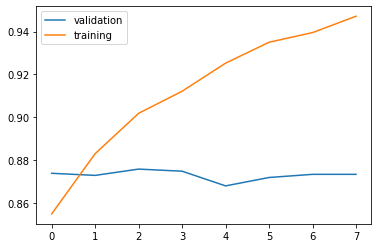

In [20]:
plt.plot(ft_history.history['val_accuracy'], label='validation')
plt.plot(ft_history.history['accuracy'], label='training')
plt.legend()
plt.show()

In [21]:
logname = CP_DIR + '/FT.csv'

df_ft_history = pd.DataFrame.from_dict(ft_history.history) 
df_ft_history.to_csv (logname, index = False, header=True)

##3.4 Analysis

In [22]:
best_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/InceptionResNetV2/FT/InceptionResNetV2-03.h5')

In [23]:
best_model.evaluate(ds_test)

32/32 [==============================] - 12s 235ms/step - loss: 0.4913 - accuracy: 0.8604 - top_k_categorical_accuracy: 0.9839


[0.4913041591644287, 0.8603515625, 0.98388671875]